In [37]:
import math
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs

from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")
%matplotlib inline

from DecisionStumpModule import DecisionStump

import logging
import yaml
from logging import config

import collections

In [44]:
class DecisionStump():

    def __init__(self):
        self.bestvalue = None
        self.bestfeature  = None
        self.bestsplit = None

    def fit(self, X, y):
        results2 = []
        for f in X.T[:]:
            results2.append(self.calcGini(f, y))
        self.bestvalue, self.bestfeature, self.bestsplit = self.calcBest(results2)
        return self

    def predict(self, X):
        return (X[:,self.bestfeature] > self.bestsplit).astype(int)

    def calcGini(self, f, y):
        results = []
        for cur in range(math.ceil(np.min(f)), math.floor(np.max(f))):

            # calc left split Gini
            temp_X = f < cur
            result_left, nl = self.calcSplit(temp_X, y, cur)

            # calc right split Gini
            temp_X = f > cur
            result_right, nr = self.calcSplit(temp_X, y, cur)

            weighted_result = result_left*nl + result_right*nr
            results.append([weighted_result, cur])
        return results

    def calcSplit(self, temp_X, y, split):
        n = temp_X.sum()
        n1 = np.logical_and(temp_X, y).astype(int).sum()
        n2 = n - n1

        n1n = n1 / n
        n2n = n2 / n

        result = 1 - (math.pow(n1n, 2) + math.pow(n2n, 2))

        return result, n/temp_X.shape[0]

    def calcBest(self, results2):
        featurenum = 0
        results3 = []
        for i in results2:
            _i = np.array(i)[:, 0]
            argminGini = _i.argmin()
            minGini = _i[_i.argmin()]
            Split = np.array(i)[argminGini, 1]
            results3.append([argminGini, minGini, Split, featurenum])
            featurenum += 1
        results3 = np.array(results3)

        bestfeature = results3[:,1].argmin()
        bestvalue = results3[bestfeature, 1]
        bestSplit = results3[bestfeature, 2]

        return bestvalue, bestfeature, bestSplit

In [53]:
class RandomStumpForest():
    
    def __init__(self):
        self.stumps = []

    def fit(self, X, y, nstumps=2, batch_size=10):
        for X_batch, y_batch in self.bootstrap(X, y, nstumps, batch_size):
            stump = DecisionStump().fit(X_batch, y_batch)
            self.stumps.append(stump)
        return self

    def predict(self, X):
        predicts = np.array([])
        counter = 0
        for stump in self.stumps:
            predict = stump.predict(X)
            if counter == 0:
                predicts = predict
            predicts = np.vstack((predicts, predict))
            counter += 1
        return self.upvote(predicts)

    def bootstrap(self, X, y, nstumps, batch_size):
        for i in range(nstumps):
            np.random.seed(42)
            perm = np.random.permutation(len(X))
            X = X[perm]
            y = y[perm]
            X_batch, y_batch = X[0:batch_size], y[0:batch_size]
            yield X_batch, y_batch

    def upvote(self, predicts):
        result = []
        c = collections.Counter()
        for i in predicts.T:
            for j in i:
                c[j] += 1
            result.append(c.most_common(1)[0][0])
            c.clear()
        return np.array(result)

0.945


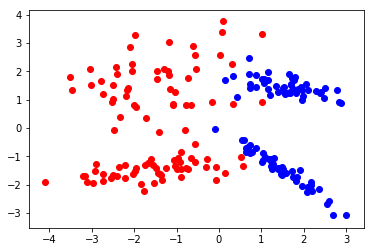

In [57]:
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=2,
    flip_y=0,
    class_sep=1.5,
    random_state=40,
)

n_classes = 2
plot_colors = ['red', 'blue']

clsf = RandomStumpForest().fit(X, y, nstumps=3, batch_size=10)
Z = clsf.predict(X)

# print(Z)
# print(y)
print(accuracy_score(y, Z))

for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color,
                cmap=plt.cm.Paired);

plt.show()